In [1]:
from os import listdir
import scipy.interpolate as sp
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seawater as sw
from tqdm import tqdm
from scipy.interpolate import griddata

In [2]:
path="/tigress/GEOCLIM/LRGROUP/shared_data/woa18/WOA18_0to1500m/"
lonmin,lonmax=35,130
latmin,latmax=-30,30
for tt in tqdm(range(1,13)):
    
    if tt == 1:
        TEMP = np.zeros((12,57,60,95))
        DOXY = np.zeros((12,57,60,95))
        PSAL = np.zeros((12,57,60,95))
        
    if tt < 10:
        t='0'+str(tt)
    else:
        t=str(tt)
        
    # TEMP
    data=xr.open_dataset(path+"temperature/woa18_decav_t"+t+"_01.nc", decode_times=False)
    tmp=data["t_an"][0,:,:,:]
    Lat_s=np.logical_and(tmp.lat>latmin,tmp.lat<latmax)
    Lon_s=np.logical_and(tmp.lon>lonmin,tmp.lon<lonmax)
    tmp=np.array(tmp)[:,Lat_s]
    tmp=np.array(tmp)[:,:,Lon_s]
    TEMP[tt-1,:,:,:] = tmp
    
    # PSAL
    data=xr.open_dataset(path+"salinity/woa18_decav_s"+t+"_01.nc", decode_times=False)
    tmp=data["s_an"][0,:,:,:]
    Lat_s=np.logical_and(tmp.lat>latmin,tmp.lat<latmax)
    Lon_s=np.logical_and(tmp.lon>lonmin,tmp.lon<lonmax)
    tmp=np.array(tmp)[:,Lat_s]
    tmp=np.array(tmp)[:,:,Lon_s]
    PSAL[tt-1,:,:,:] = tmp
    
    # DOXY
    data=xr.open_dataset(path+"oxygen/woa18_all_o"+t+"_01.nc", decode_times=False)
    tmp=data["o_an"][0,:,:,:]
    Lat_s=np.logical_and(tmp.lat>latmin,tmp.lat<latmax)
    Lon_s=np.logical_and(tmp.lon>lonmin,tmp.lon<lonmax)
    tmp=np.array(tmp)[:,Lat_s]
    tmp=np.array(tmp)[:,:,Lon_s]
    DOXY[tt-1,:,:,:] = tmp
    
    depth_1500 = data.depth
    

LON=np.array(data.lon)[Lon_s]
LAT=np.array(data.lat)[Lat_s]
DEPTH=np.array(depth_1500)

# DEPTH to PRES
PRES = np.zeros((57,60,95))*np.nan
n = len(LAT)
m = len(LON)

for ii,lat in zip(range(len(LAT)),LAT):
    for jj in range(len(LON)):
        PRES[:,ii,jj]=sw.eos80.pres(DEPTH, [lat for i in range(len(DEPTH))])
        
ds_grid=xr.Dataset(coords={'month': np.arange(1,13),
                        'depth': DEPTH,
                        'lon': LON,
                        'lat': LAT})
# add to dataset
ds_grid['temp_grid'] = xr.DataArray(TEMP,dims = ['month','depth','lat','lon'],coords =[np.arange(1,13),DEPTH,LAT,LON])
ds_grid['psal_grid'] = xr.DataArray(PSAL,dims = ['month','depth','lat','lon'],coords =[np.arange(1,13),DEPTH,LAT,LON])
ds_grid['doxy_grid'] = xr.DataArray(DOXY,dims = ['month','depth','lat','lon'],coords =[np.arange(1,13),DEPTH,LAT,LON])
ds_grid['pres_grid'] = xr.DataArray(PRES,dims = ['depth','lat','lon'],coords =[DEPTH,LAT,LON])

ds_grid 

100%|██████████| 12/12 [00:03<00:00,  3.60it/s]


<xarray.Dataset>
Dimensions:    (depth: 57, lat: 60, lon: 95, month: 12)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth      (depth) float32 0.0 5.0 10.0 15.0 ... 1350.0 1400.0 1450.0 1500.0
  * lon        (lon) float32 35.5 36.5 37.5 38.5 ... 126.5 127.5 128.5 129.5
  * lat        (lat) float32 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
Data variables:
    temp_grid  (month, depth, lat, lon) float64 25.52 25.49 25.47 ... nan nan
    psal_grid  (month, depth, lat, lon) float64 35.45 35.47 35.47 ... nan nan
    doxy_grid  (month, depth, lat, lon) float64 217.1 216.1 214.1 ... nan nan
    pres_grid  (depth, lat, lon) float64 0.0 0.0 0.0 ... 1.516e+03 1.516e+03

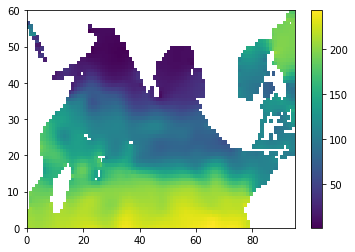

In [3]:
plt.pcolormesh(ds_grid.doxy_grid[0,-30,:,:])
plt.colorbar()

# Interpolation

In [4]:
interp_min=0 # min pressure (in dbar)
interp_max=1000 # max pressure (in dbar)
interp_step=5

PRES_i=np.linspace(interp_min,interp_max,1+int((interp_max-interp_min)/interp_step))

n = len(LAT)
m = len(LON)
t = 12
with tqdm(total=n * m * t) as pbar:
    for tt in range(12):
        
        if tt == 0:
            TEMP_i = np.zeros((12,201,60,95))*np.nan
            DOXY_i = np.zeros((12,201,60,95))*np.nan
            PSAL_i = np.zeros((12,201,60,95))*np.nan
                    
        for ii,lat in zip(range(len(LAT)),LAT):
            for jj in range(len(LON)):

                # conversion [m] -> [dbar]:
                pres=sw.eos80.pres(DEPTH, [lat for i in range(len(DEPTH))])

                # temp,psal,doxy selection
                temp,psal,doxy = TEMP[tt,:,ii,jj],PSAL[tt,:,ii,jj],DOXY[tt,:,ii,jj]

                # interpolation
                ft = sp.interp1d(pres,temp,bounds_error=False,fill_value=np.nan)
                TEMP_i[tt,:,ii,jj] = ft(PRES_i)
                    
                fo = sp.interp1d(pres,doxy,bounds_error=False,fill_value=np.nan)
                DOXY_i[tt,:,ii,jj] = fo(PRES_i)
                fs = sp.interp1d(pres,psal,bounds_error=False,fill_value=np.nan)
                PSAL_i[tt,:,ii,jj] = fs(PRES_i)
                
                pbar.update(1)
            

            
ds_i=xr.Dataset(coords={'month': np.arange(1,13),
                        'pres': PRES_i,
                        'lon': LON,
                        'lat': LAT})
# add to dataset
ds_i['temp_grid'] = xr.DataArray(TEMP_i,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),PRES_i,LAT,LON])
ds_i['psal_grid'] = xr.DataArray(PSAL_i,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),PRES_i,LAT,LON])
ds_i['doxy_grid'] = xr.DataArray(DOXY_i,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),PRES_i,LAT,LON])
ds_i          

100%|██████████| 68400/68400 [00:14<00:00, 4832.83it/s]


<xarray.Dataset>
Dimensions:    (lat: 60, lon: 95, month: 12, pres: 201)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * pres       (pres) float64 0.0 5.0 10.0 15.0 20.0 ... 985.0 990.0 995.0 1e+03
  * lon        (lon) float32 35.5 36.5 37.5 38.5 ... 126.5 127.5 128.5 129.5
  * lat        (lat) float32 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
Data variables:
    temp_grid  (month, pres, lat, lon) float64 25.52 25.49 25.47 ... nan 4.5 nan
    psal_grid  (month, pres, lat, lon) float64 35.45 35.47 35.47 ... 34.44 nan
    doxy_grid  (month, pres, lat, lon) float64 217.1 216.1 214.1 ... 75.65 nan

In [5]:
# get merged data from tigress
path_AWG = '../Merged/'
infn_AWG = 'Profiles_temp_psal_doxy_processed.nc'

ds_AWG = xr.open_dataset(path_AWG + infn_AWG)
ds_AWG

<xarray.Dataset>
Dimensions:  (pres: 201, time: 306118)
Coordinates:
    prof     (time) int32 ...
  * time     (time) datetime64[ns] 1827-10-30 1836-05-15 ... 2020-02-07
  * pres     (pres) int32 0 5 10 15 20 25 30 35 ... 970 975 980 985 990 995 1000
Data variables:
    temp     (time, pres) float32 ...
    psal     (time, pres) float32 ...
    doxy     (time, pres) float32 ...
    lat      (time) float32 ...
    lon      (time) float32 ...
    type     (time) int32 ...

In [6]:
xx,yy = np.meshgrid(ds_i.lon,ds_i.lat)
xx = xx.flatten()
yy = yy.flatten()

lons= np.array(ds_AWG.lon)
lats = np.array(ds_AWG.lat)
months = np.array(ds_AWG.time.dt.month)

TEMP_AWG = np.zeros((len(months),len(PRES_i)))*np.nan
DOXY_AWG = np.zeros((len(months),len(PRES_i)))*np.nan
PSAL_AWG = np.zeros((len(months),len(PRES_i)))*np.nan
lon_AWG = np.zeros(len(months))*np.nan
lat_AWG = np.zeros(len(months))*np.nan
month_AWG = np.array(months)

n = len(ds_i.month)
m = len(PRES_i)
with tqdm(total=n * m) as pbar:
    for tt in range(n):
        for dd in range(m):

            temp = np.array(ds_i.temp_grid[tt,dd,:,:])
            psal = np.array(ds_i.psal_grid[tt,dd,:,:])
            doxy = np.array(ds_i.doxy_grid[tt,dd,:,:])
            indq = months == np.array(ds_i.month[tt])   
            lonq = lons[indq]
            latq = lats[indq]

            # find the lons and lats of TCD vals at this time

            points = np.array( (xx,yy) ).T
            temp_values = temp.flatten()
            psal_values = psal.flatten()
            doxy_values = doxy.flatten()

            TEMP_AWG[indq,dd] = griddata(points, temp_values, (lonq,latq) ,method='linear')
            PSAL_AWG[indq,dd] = griddata(points, psal_values, (lonq,latq) ,method='linear')
            DOXY_AWG[indq,dd] = griddata(points, doxy_values, (lonq,latq) ,method='linear')
            lon_AWG[indq] = lonq
            lat_AWG[indq] = latq
            pbar.update(1)

# set the places that are nans in AWG temp or doxy to nan
ind = np.isnan(ds_AWG.temp)
TEMP_AWG[ind] = np.nan

ind = np.isnan(ds_AWG.doxy)
DOXY_AWG[ind] = np.nan

ind = np.isnan(ds_AWG.psal)
PSAL_AWG[ind] = np.nan

ds=xr.Dataset(coords={'month': month_AWG,
                        'pres': PRES_i})

ds=xr.Dataset(coords={'month': month_AWG,
                        'pres': PRES_i})
# add to dataset
ds['temp'] = xr.DataArray(TEMP_AWG,dims = ['month','pres'],coords =[month_AWG,PRES_i])
ds['psal'] = xr.DataArray(PSAL_AWG,dims = ['month','pres'],coords =[month_AWG,PRES_i])
ds['doxy'] = xr.DataArray(DOXY_AWG,dims = ['month','pres'],coords =[month_AWG,PRES_i])
ds['lon'] = xr.DataArray(lon_AWG,dims = ['month'],coords =[month_AWG])
ds['lat'] = xr.DataArray(lat_AWG,dims = ['month'],coords =[month_AWG])
ds 

100%|██████████| 2412/2412 [10:33<00:00,  3.80it/s]


<xarray.Dataset>
Dimensions:  (month: 306118, pres: 201)
Coordinates:
  * month    (month) int64 10 5 12 2 5 2 2 3 3 3 2 2 ... 2 2 2 2 2 2 2 2 2 2 2 2
  * pres     (pres) float64 0.0 5.0 10.0 15.0 20.0 ... 985.0 990.0 995.0 1e+03
Data variables:
    temp     (month, pres) float64 nan nan nan nan ... 6.755 6.726 6.697 6.668
    psal     (month, pres) float64 nan nan nan nan ... 34.95 34.95 34.95 34.94
    doxy     (month, pres) float64 nan nan nan nan ... 53.83 54.12 54.41 54.7
    lon      (month) float64 119.8 41.0 85.33 98.5 ... 64.74 73.59 53.53 84.37
    lat      (month) float64 -18.0 -27.5 -7.9 -26.78 ... 14.39 -3.16 11.25 1.808

In [7]:
# # process to correspond to SLA locations

# # SLA
# path_SLA = '../SLA/'
# infn_SLA = 'sla_grid_processed.nc'

# ds_SLA = xr.open_dataset(path_SLA + infn_SLA)
# ds_SLA

In [8]:
# xx,yy = np.meshgrid(ds_i.lon,ds_i.lat)
# xx = xx.flatten()
# yy = yy.flatten()

# xx_SLA,yy_SLA = np.meshgrid(ds_SLA.lon,ds_SLA.lat)

# TEMP_SLA = np.zeros((len(ds_grid.month),len(PRES),len(ds_SLA.lat),len(ds_SLA.lon)))*np.nan
# DOXY_SLA = np.zeros((len(ds_grid.month),len(PRES),len(ds_SLA.lat),len(ds_SLA.lon)))*np.nan
# PSAL_SLA = np.zeros((len(ds_grid.month),len(PRES),len(ds_SLA.lat),len(ds_SLA.lon)))*np.nan
# PRES_SLA = np.zeros((len(PRES),len(ds_SLA.lat),len(ds_SLA.lon)))*np.nan

# n = len(ds_grid.month)
# m = len(DEPTH)
# with tqdm(total=n * m) as pbar:
#     for tt in range(n):
#         for dd in range(m):

#             temp = np.array(TEMP[tt,dd,:,:])
#             psal = np.array(PSAL[tt,dd,:,:])
#             doxy = np.array(DOXY[tt,dd,:,:])
#             pres = np.array(PRES[dd,:,:])

#             # find the lons and lats of TCD vals at this time

#             points = np.array( (xx,yy) ).T
#             temp_values = temp.flatten()
#             psal_values = psal.flatten()
#             doxy_values = doxy.flatten()
#             pres_values = pres.flatten()

#             TEMP_SLA[tt,dd,:,:] = griddata(points, temp_values, (xx_SLA,yy_SLA) ,method='linear')
#             PSAL_SLA[tt,dd,:,:] = griddata(points, psal_values, (xx_SLA,yy_SLA) ,method='linear')
#             DOXY_SLA[tt,dd,:,:] = griddata(points, doxy_values, (xx_SLA,yy_SLA) ,method='linear')
#             PRES_SLA[dd,:,:] = griddata(points, pres_values, (xx_SLA,yy_SLA) ,method='linear')
#             pbar.update(1)
            


# ds_SLA_grid=xr.Dataset(coords={'month': np.arange(1,13),
#                         'depth': DEPTH,
#                         'lon': ds_SLA.lon,
#                         'lat': ds_SLA.lat})
# # add to dataset
# ds_SLA_grid['temp_grid'] = xr.DataArray(TEMP_SLA,dims = ['month','depth','lat','lon'],coords =[np.arange(1,13),DEPTH,ds_SLA.lat,ds_SLA.lon])
# ds_SLA_grid['psal_grid'] = xr.DataArray(PSAL_SLA,dims = ['month','depth','lat','lon'],coords =[np.arange(1,13),DEPTH,ds_SLA.lat,ds_SLA.lon])
# ds_SLA_grid['doxy_grid'] = xr.DataArray(DOXY_SLA,dims = ['month','depth','lat','lon'],coords =[np.arange(1,13),DEPTH,ds_SLA.lat,ds_SLA.lon])
# ds_SLA_grid['pres_grid'] = xr.DataArray(PRES_SLA,dims = ['depth','lat','lon'],coords =[DEPTH,ds_SLA.lat,ds_SLA.lon])

# # # set places where sla is nan to nan
# # ind = np.isnan(np.array(ds_SLA.daily_sla))
# # ds_SLA_grid.temp_grid = ds_SLA_grid.temp_grid.where(~ind)
# # ds_SLA_grid.temp_grid = ds_SLA_grid.temp_grid.where(~ind)
# # ds_SLA_grid.temp_grid = ds_SLA_grid.temp_grid.where(~ind)
# # ds_SLA_grid.temp_grid = ds_SLA_grid.temp_grid.where(~ind)

# ds_SLA_grid 

# remove any negative doxy values

In [9]:
# set negative oxygen values to nan
ds['doxy'] = ds.doxy.where(ds.doxy >= 0)
ds_grid['doxy_grid'] = ds_grid.doxy_grid.where(ds_grid.doxy_grid >= 0)
ds_i['doxy_grid'] = ds_i.doxy_grid.where(ds_i.doxy_grid >= 0)
# ds_SLA_grid['doxy_grid'] = ds_SLA_grid.doxy_grid.where(ds_SLA_grid.doxy_grid >= 0)

# plt.plot(ds.doxy.min(dim = 'pres'),'.')
# plt.ylim([-1,1])
# plt.xlabel('Profile No.')
# plt.ylabel('min doxy negs removed')

# SAVE

In [10]:
# save_path = '/projects/GEOCLIM/LRGROUP/jennap/Modulation_of_Coastal_Hypoxia_by_the_IOD/data/'

import os

# AWG data
outfn = 'woa_awg_processed.nc'

# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds.to_netcdf(outfn,mode='w',format = "NETCDF4")

# Gridded data

outfn = 'woa_grid_processed.nc'

# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_grid.to_netcdf(outfn,mode='w',format = "NETCDF4")

# Gridded data

# outfn = 'woa_sla_processed.nc'

# # delete if already present
# if os.path.isfile(outfn):
#     os.remove(outfn)

# ds_SLA_grid.to_netcdf(outfn,mode='w',format = "NETCDF4")